In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random as random
from copy import deepcopy
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# 1 Assignment - kmeans algorithm

In [3]:
def kmeans(X, k, max_iter=100):
    """ Performs k-means clustering

    Input:
    X: (d x n) data matrix with each datapoint in one column
    k: number of clusters
    max_iter: maximum number of iterations

    Output:
    mu: (d x k) matrix with each cluster center in one column
    r: assignment vector
    """
    # initailize k random centroids at data mean
    X_mean = np.mean(X, axis = 0)
    w_init = np.array([np.random.normal(X_mean[i],1,k) for i in range(len(X_mean))])
    w_q = w_init
    converged = False
    iteration = 1
    m_q = np.zeros(len(X))
    m_q_old = deepcopy(m_q)
    while (not converged) & (iteration <= max_iter):
        # calculate distance to centroids
        D = np.linalg.norm(X[None, :] - w_q.T[:,None], axis = 2)
        # assign every data point to its nearest centroids
        m_q = np.argmin(D, axis=0)
        # assign random data point to not empty centroids
        m_empty = [x for x in range(k) if x not in np.unique(m_q)]
        for m in m_empty:
            m_q[random.randint(0,len(X)-1)] = m
        # calculate position of centroids as mean of assigned data
        w_q.T[np.unique(m_q)] = [np.sum(X[m_q == j], axis = 0) / (np.sum(m_q == j)) for j in np.unique(m_q)]
        
        # calculate objective
        loss = np.sum([np.sum((X[m_q == j, :] - w_q[:,j])**2) for j in np.unique(m_q)])
        print('iteration-step: ' + str(iteration))
        print('number of changes in assignment: ' + str(list(m_q == m_q_old).count(False)))
        print('loss function value: ' + str(loss))
        if (m_q == m_q_old).all():
            converged = True
            break
        
        m_q_old = deepcopy(m_q)
        iteration+=1
    return w_q.T, m_q, loss

In [4]:
# Test set
k=3
X = np.array([[0., 1., 1., 10., 10.25, 11., 10., 10.25, 11.],
                  [0., 0., 1.,  0.,   0.5,  0.,  5.,   5.5,  5.]]).T
perfect_r = [1,0,1,2,2,1,2,2,2]

In [5]:
mu, r, loss =  kmeans(X,3)

iteration-step: 1
number of changes in assignment: 6
loss function value: 2.7500000000000004
iteration-step: 2
number of changes in assignment: 0
loss function value: 2.7500000000000004


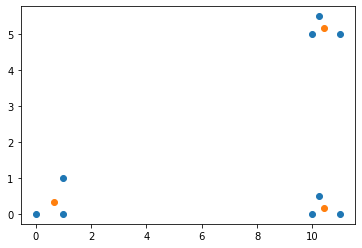

In [6]:
plt.plot(X[:,0], X[:,1], 'o')
plt.plot (mu.T[0], mu.T[1], 'o')

In [7]:
r

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

In [8]:
def kmeans_agglo(X, r):
    """ Performs agglomerative clustering with k-means criterion

    Input:
    X: (d x n) data matrix with each datapoint in one column
    r: assignment vector

    Output:
    R: (k-1) x n matrix that contains cluster memberships before each step
    kmloss: vector with loss after each step
    mergeidx: (k-1) x 2 matrix that contains merge idx for each step
    """
   
    def kmeans_crit(X, r):
        """ Computes k-means criterion

        Input: 
        X: (d x n) data matrix with each datapoint in one column
        r: assignment vector

        Output:
        value: scalar for sum of euclidean distances to cluster centers
        """
        # calculate init centroids
        w_q = np.array([np.sum(X[r == j], axis = 0) / (np.sum(r == j)) for j in np.unique(r)])
        # compute initial clustering cost
        loss = np.sum([np.sum((X[r == j, :] - w_q.T[:,np.unique(r) == j].reshape(len(w_q.T)))**2) for j in np.unique(r)])
        return loss
    
    # initialization
    k = len(np.unique(r))
    n, d = np.shape(X)
    R = np.zeros((k-1,n))
    kmloss = np.zeros((k,1)) 
    mergeidx = np.zeros((k-1,2))
    
    kmloss[0] = kmeans_crit(X,r) 
    
    
    for l in range(1,k):
        R[l-1] = r
        # calculate init centroids
        w_q = np.array([np.sum(X[r == j], axis = 0) / (np.sum(r == j)) for j in np.unique(r)])
        # calculate distance between centroids -> covariance matrix
        D = np.linalg.norm(w_q[None, :] - w_q[:,None], axis = 2)
        # sort covariance ascending order
        pairs = list(zip(np.argsort(D,kind='mergesort', axis = None)//len(D), np.argsort(D,kind='mergesort', axis = None)%len(D))) # zeile / spalte
        # determine centroid pair with smallest loss, Caveat first elements are 0 explain the diagonal of the cov-matrix
        min_pair_idx = pairs[k-l+1]
        # get names of merged clusters by r (clusters used before have the highest index plus 1 )
        min_pair = np.unique(r)[np.array(min_pair_idx)]  
        mergeidx[l-1] = min_pair
        #if np.isin(mergeidx[l-1, 0], mergeidx[:l-1]):
        #    mergeidx[l-1, 0] = k+l-1

        # new cluster membership
        r[np.isin(r, min_pair)] = k+l-1
        # new kmloss
        kmloss[l] = kmeans_crit(X,r)
    return R, kmloss, mergeidx


In [9]:
R, kmloss, mergeidx = kmeans_agglo(X,r)

In [10]:
def agglo_dendro(kmloss, mergeidx):
    """ Plots dendrogram for agglomerative clustering

    Input:
    kmloss: vector with loss after each step
    mergeidx: (k-1) x 2 matrix that contains merge idx for each step
    """
    fourth_column = 2*np.ones((len(mergeidx),1)) # necessary for dendogram function, sample count
    Z = np.concatenate([mergeidx, kmloss[1:], fourth_column], axis = 1)
    
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    )
    return

In [11]:
kmloss

array([[  2.75      ],
       [ 40.25      ],
       [241.26388889]])

In [12]:
mergeidx

array([[1., 2.],
       [0., 3.]])

In [13]:
R

array([[0., 0., 0., 1., 1., 1., 2., 2., 2.],
       [0., 0., 0., 3., 3., 3., 3., 3., 3.]])

In [14]:
k = np.unique(mergeidx)

In [15]:
fourth_column = 2*np.ones((len(mergeidx),1))

In [16]:
np.concatenate([mergeidx, kmloss[1:], fourth_column], axis = 1)

array([[  1.        ,   2.        ,  40.25      ,   2.        ],
       [  0.        ,   3.        , 241.26388889,   2.        ]])

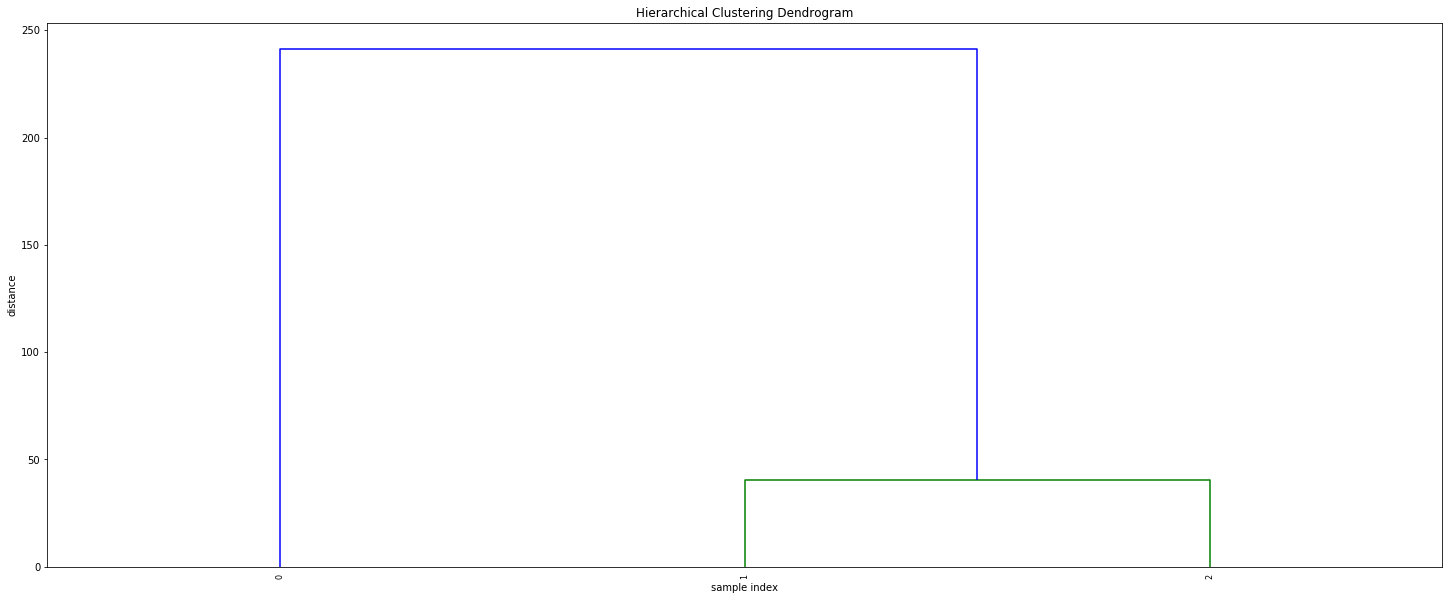

In [17]:
agglo_dendro(kmloss, mergeidx)

{'icoord': [[15.0, 15.0, 25.0, 25.0], [5.0, 5.0, 20.0, 20.0]],
 'dcoord': [[0.0, 40.25, 40.25, 0.0],
  [0.0, 241.26388888888889, 241.26388888888889, 40.25]],
 'ivl': ['0', '1', '2'],
 'leaves': [0, 1, 2],
 'color_list': ['g', 'b']}

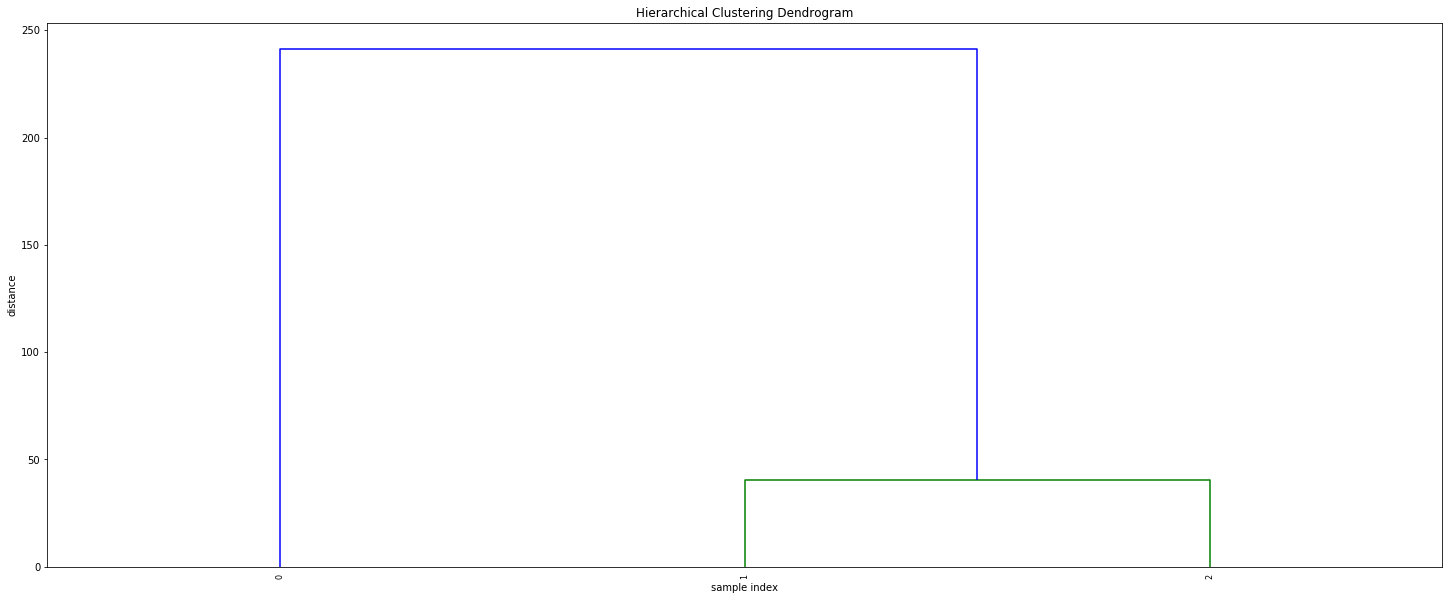

In [512]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

In [20]:
for _ in range(10):
    mu, r, _ = kmeans(X, k=3)
    r = r.flatten()
    R, kmloss, mergeidx = kmeans_agglo(X, r)
    mergeidx = np.array(mergeidx, dtype=int)
    if set([int(r[3]), int(r[6])]) == set(mergeidx[0, :]):
        worked = True
        imp.agglo_dendro(kmloss, mergeidx)
        break
    if not worked:
        raise AssertionError('test_agglo: the first merge is not correct.')


iteration-step: 1
number of changes in assignment: 3
loss function value: 39.416666666666664
iteration-step: 2
number of changes in assignment: 0
loss function value: 39.416666666666664


NameError: name 'worked' is not defined

In [30]:
# agglo fails due to updated cluster names, which is mandatory for the dendogram plot -> question for Q&A

In [29]:
worked1 = False
worked2 = False
for _ in range(10):
    mu, r, _ = kmeans(X, k=3)
    if (r[0]==r[1]==r[2]!=r[3] and r[3]==r[4]==r[5]!=r[6] and r[6]==r[7]==r[8]):
        worked1 = True

    # test one cluster center
    if (np.linalg.norm(mu[0] - [10.41666, 0.1666]) < 0.1 or
        np.linalg.norm(mu[1] - [10.41666, 0.1666]) < 0.1 or
        np.linalg.norm(mu[2] - [10.41666, 0.1666]) < 0.1):
            worked2 = True
    if worked1 and worked2:
        break
if not worked1:
    raise AssertionError('test_kmeans cluster assignments are wrong.')
if not worked2:
    raise AssertionError('test_kmeans did not find the correct cluster center.')


iteration-step: 1
number of changes in assignment: 6
loss function value: 2.75
iteration-step: 2
number of changes in assignment: 0
loss function value: 2.75
